# Face Mask Detection

Ссылка на датасет: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection/data

Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. With this dataset, it is possible to create a model to detect people wearing masks, not wearing them, or wearing masks improperly.

This dataset contains 853 images belonging to the 3 classes, as well as their bounding boxes in the PASCAL VOC format.
   
The classes are:

- With mask;
- Without mask;
- Mask worn incorrectly.

### Пример фото из датасета и его описание:

<img src="maksssksksss0.png"/>

### Загрузка датасета

In [21]:
import kagglehub

path = kagglehub.dataset_download("andrewmvd/face-mask-detection")
print("Path to dataset files:", path)

Path to dataset files: /home/phoboss/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1


### Создание необходимых каталогов
- xml_folder - каталог с описанием изображений
- images_folder - каталог с изображениями
- output_folder - каталог с обрезанными изображениями лица

In [22]:
xml_folder = path + '/annotations'
images_folder = path + '/images'
output_folder = "cropped_images/"

### Парсинг данных из xml-формата и создание из них датафрейма
Для удобства сразу же обрезаем изображения

In [23]:
import xml.etree.ElementTree as ET
import pandas as pd
import glob
import os
from PIL import Image

data = []

for xml_file in glob.glob(os.path.join(xml_folder, "*.xml")):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find("filename").text
    img_path = os.path.join(images_folder, filename)

    if not os.path.exists(img_path):
        print(f"Файл {img_path} не найден.")
        continue

    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)
    
    image = Image.open(img_path)

    for i, obj in enumerate(root.findall("object")):
        label = obj.find("name").text
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        
        cropped = image.crop((xmin, ymin, xmax, ymax))

        cropped_filename = f"{filename.split('.')[0]}_{i}_{label}.png"
        cropped_path = os.path.join(output_folder, cropped_filename)
        cropped.save(cropped_path)

        data.append([filename, cropped_filename, width, height, label, xmin, ymin, xmax, ymax])

df = pd.DataFrame(data, columns=["filename", "cropped_filename", "width", "height", "label", "xmin", "ymin", "xmax", "ymax"])
df.to_csv("cropped_annotations.csv", index=False)
print(df)

                 filename                    cropped_filename  width  height  \
0     maksssksksss281.png     maksssksksss281_0_with_mask.png    301     400   
1     maksssksksss413.png     maksssksksss413_0_with_mask.png    400     210   
2     maksssksksss413.png     maksssksksss413_1_with_mask.png    400     210   
3     maksssksksss413.png     maksssksksss413_2_with_mask.png    400     210   
4     maksssksksss556.png     maksssksksss556_0_with_mask.png    400     198   
...                   ...                                 ...    ...     ...   
4067  maksssksksss804.png    maksssksksss804_11_with_mask.png    400     258   
4068  maksssksksss710.png  maksssksksss710_0_without_mask.png    400     200   
4069  maksssksksss710.png     maksssksksss710_1_with_mask.png    400     200   
4070  maksssksksss710.png     maksssksksss710_2_with_mask.png    400     200   
4071  maksssksksss407.png     maksssksksss407_0_with_mask.png    301     400   

             label  xmin  ymin  xmax  y

In [24]:
df['label'].value_counts()

with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: label, dtype: int64

In [27]:
df = df[df['label'] != 'mask_weared_incorrect']
df['label'].value_counts()

with_mask       3232
without_mask     717
Name: label, dtype: int64

### Формирование выборок с нужными начальными параметрами

In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"])

data_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = data_gen.flow_from_dataframe(
    dataframe=train_df,
    directory="cropped_images/",
    x_col="cropped_filename",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)

test_data_gen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    directory="cropped_images/",
    x_col="cropped_filename",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

print(train_generator.class_indices)
print(f"Train size: {len(train_generator)} batches")
print(f"Test size: {len(test_generator)} batches")

Found 3159 validated image filenames belonging to 2 classes.
Found 790 validated image filenames belonging to 2 classes.
{'with_mask': 0, 'without_mask': 1}
Train size: 99 batches
Test size: 25 batches


### Задание модели CNN

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import metrics

n_classes = 1
input_shape = (224, 224, 3)

model = models.Sequential([
    layers.Conv2D(25, kernel_size=3, strides=1, padding='same', input_shape=input_shape),  # 25 x 224 x 224
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),  # 25 x 112 x 112

    layers.Conv2D(50, kernel_size=3, strides=1, padding='same'),  # 50 x 112 x 112
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.2),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),  # 50 x 56 x 56

    layers.Conv2D(75, kernel_size=3, strides=1, padding='same'),  # 75 x 56 x 56
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),  # 75 x 28 x 28

    layers.Conv2D(100, kernel_size=3, strides=1, padding='same'),  # 100 x 28 x 28
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),  # 100 x 14 x 14

    layers.GlobalAveragePooling2D(),  # 100 x 1 x 1

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.AUC()])
model.summary()

/home/phoboss/anaconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 25)   │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 25)   │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 25)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 25)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 50)   │        11,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 50)   │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 50)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 50)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 75)     │        33,825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 75)     │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 100)    │        67,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 100)    │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 28, 28, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 100)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        51,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,650 (650.98 KB)

 Trainable params: 166,150 (649.02 KB)

 Non-trainable params: 500 (1.95 KB)

### Обучение модели

In [13]:
history = model.fit(train_generator, epochs=15)

Epoch 1/15


/home/phoboss/anaconda3/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-03-05 00:00:16.733389: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 160563200 exceeds 10% of free system memory.
2025-03-05 00:00:17.455272: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 160563200 exceeds 10% of free system memory.
2025-03-05 00:00:17.542360: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 160563200 exceeds 10% of free system memory.
2025-03-05 00:00:17.654850: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40140800 exceeds 10% of free system memory.
2025-03-05 00:00:17.67608

99/99 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 0.8621 - auc_1: 0.8908 - loss: 0.2925
Epoch 2/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 0.9162 - auc_1: 0.9523 - loss: 0.2100
Epoch 3/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.9288 - auc_1: 0.9610 - loss: 0.1762
Epoch 4/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.9300 - auc_1: 0.9620 - loss: 0.1889
Epoch 5/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.9226 - auc_1: 0.9606 - loss: 0.1898
Epoch 6/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.9363 - auc_1: 0.9664 - loss: 0.1654
Epoch 7/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.9416 - auc_1: 0.9648 - loss: 0.1686
Epoch 8/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.9318 - auc_1: 0.9682 - loss: 0.1681
Epoch 9/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.9419 - auc_1: 0.9784 - loss: 0.1445
Epoch 10/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.9437 - auc_1: 0.9787 - loss: 0.1396


In [14]:
model.save('mask_detection_v2.h5')

### Изменение loss и accuracy во время обучения

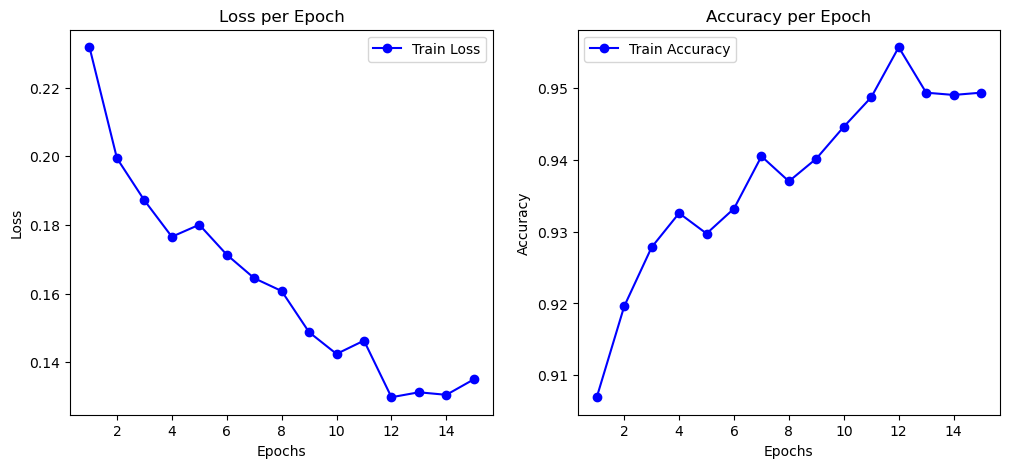

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
accuracy = history.history['accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

### Проверка модели

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import load_model

model = load_model('mask_detection_v2.h5')

predictions = model.predict(test_generator)
predicted_labels = predictions.round()
true_labels = test_generator.classes

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

precision = precision_score(true_labels, predicted_labels, average='weighted')
print(f"Precision: {precision}")

recall = recall_score(true_labels, predicted_labels, average='weighted')
print(f"Recall: {recall}\n")

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 591ms/step
Accuracy: 0.9645569620253165
Precision: 0.9652931641010437
Recall: 0.9645569620253165

Confusion Matrix:
[[630  17]
 [ 11 132]]


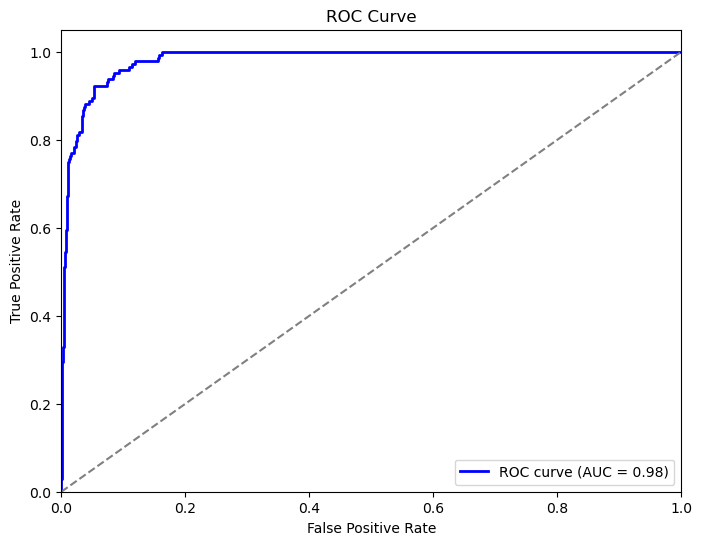

In [20]:
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()